In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.decomposition import PCA
from statsmodels.tsa.api import ARIMA
import statsmodels.tsa.stattools as tsat
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from fredapi import Fred

import warnings
warnings.filterwarnings('ignore')

---
# 0. Data Collection

#### FRED API

In [2]:
fred = Fred(api_key='923766e61730ee1dbda318b45ca1da35')

#### The target: S&P/Case-ShillerU.S. National Home Price Index

In [3]:
data = pd.DataFrame()
HPI = fred.get_series('CSUSHPISA')
data['date'] = HPI.index
data['HPIX'] = HPI.values
data = data[~np.isnan(data['HPIX'])]
data.reset_index(drop=True, inplace=True)
data

,date,HPIX
0,1987-01-01,63.964
1,1987-02-01,64.424
2,1987-03-01,64.736
3,1987-04-01,65.132
4,1987-05-01,65.563
...,...,...
434,2023-03-01,298.396
435,2023-04-01,300.208
436,2023-05-01,302.685
437,2023-06-01,304.741


#### other indicators relevant to the home price index

In [4]:
# GDP
GDP = fred.get_series('GDP')
# M2 money
M2 = fred.get_series('M2SL')
# Consumer Price Index for All Urban Consumers
CPI = fred.get_series('CPIAUCSL')
# Interest rate: Federal Funds Effective Rate
Interest = fred.get_series('FEDFUNDS')
# Personal saving
Psave = fred.get_series('PSAVE')
# Employment rate
Employ = fred.get_series('LNS12300060')
# Population level
Popu = fred.get_series('CNP16OV')
# Salary level: Compensation of Employees, Received: Wage and Salary Disbursements
Salary = fred.get_series('A576RC1')
# Nasdaq
Nasdaq = fred.get_series('NASDAQCOM')

---
# 1. Data pre-processing

#### check if the data is time-continuous

In [5]:
time_diff = (data['date'] - data['date'].shift(1)) / np.timedelta64(1, 'M')
time_diff.max(), time_diff.min()

(1.0185014065997249, 0.9199367543481386)

#### merge the dataset

In [6]:
# since the frequency of the data might differ
# need to merge the data
# and make sure there is no look-ahead
def merge_single(ori, app):
    '''
    Add app series to ori dataframe
    use searchsorted so there is no lookahead
    '''
    app = app.fillna(method='ffill')
    insertix = np.searchsorted(app.index, ori['date'])
    insertix[insertix == len(app)] = len(app)-1
    return app.values[insertix]

In [7]:
data['GDP'] = merge_single(data, GDP)
data['M2'] = merge_single(data, M2)
data['CPI'] = merge_single(data, CPI)
data['Interest'] = merge_single(data, Interest)
data['Psave'] = merge_single(data, Psave)
data['Employ'] = merge_single(data, Employ)
data['Popu'] = merge_single(data, Popu)
data['Salary'] = merge_single(data, Salary)
data['Nasdaq'] = merge_single(data, Nasdaq)

#### merged dataset

In [8]:
data.head()

,date,HPIX,GDP,M2,CPI,Interest,Psave,Employ,Popu,Salary,Nasdaq
0,1987-01-01,63.964,4722.156,2743.9,111.4,6.43,290.040,77.7,181827.0,2175.1,348.83
1,1987-02-01,64.424,4806.160,2747.5,111.8,6.10,216.931,77.9,181998.0,2193.4,397.18
2,1987-03-01,64.736,4806.160,2753.7,112.2,6.13,216.931,78.0,182179.0,2209.5,423.91
3,1987-04-01,65.132,4806.160,2767.7,112.7,6.37,216.931,78.2,182344.0,2215.2,428.34
4,1987-05-01,65.563,4884.555,2772.9,113.0,6.85,244.481,78.4,182533.0,2232.9,418.44


#### sanity check

In [9]:
data.isnull().any()

date        False
HPIX        False
GDP         False
M2          False
CPI         False
Interest    False
Psave       False
Employ      False
Popu        False
Salary      False
Nasdaq      False
dtype: bool

#### overview

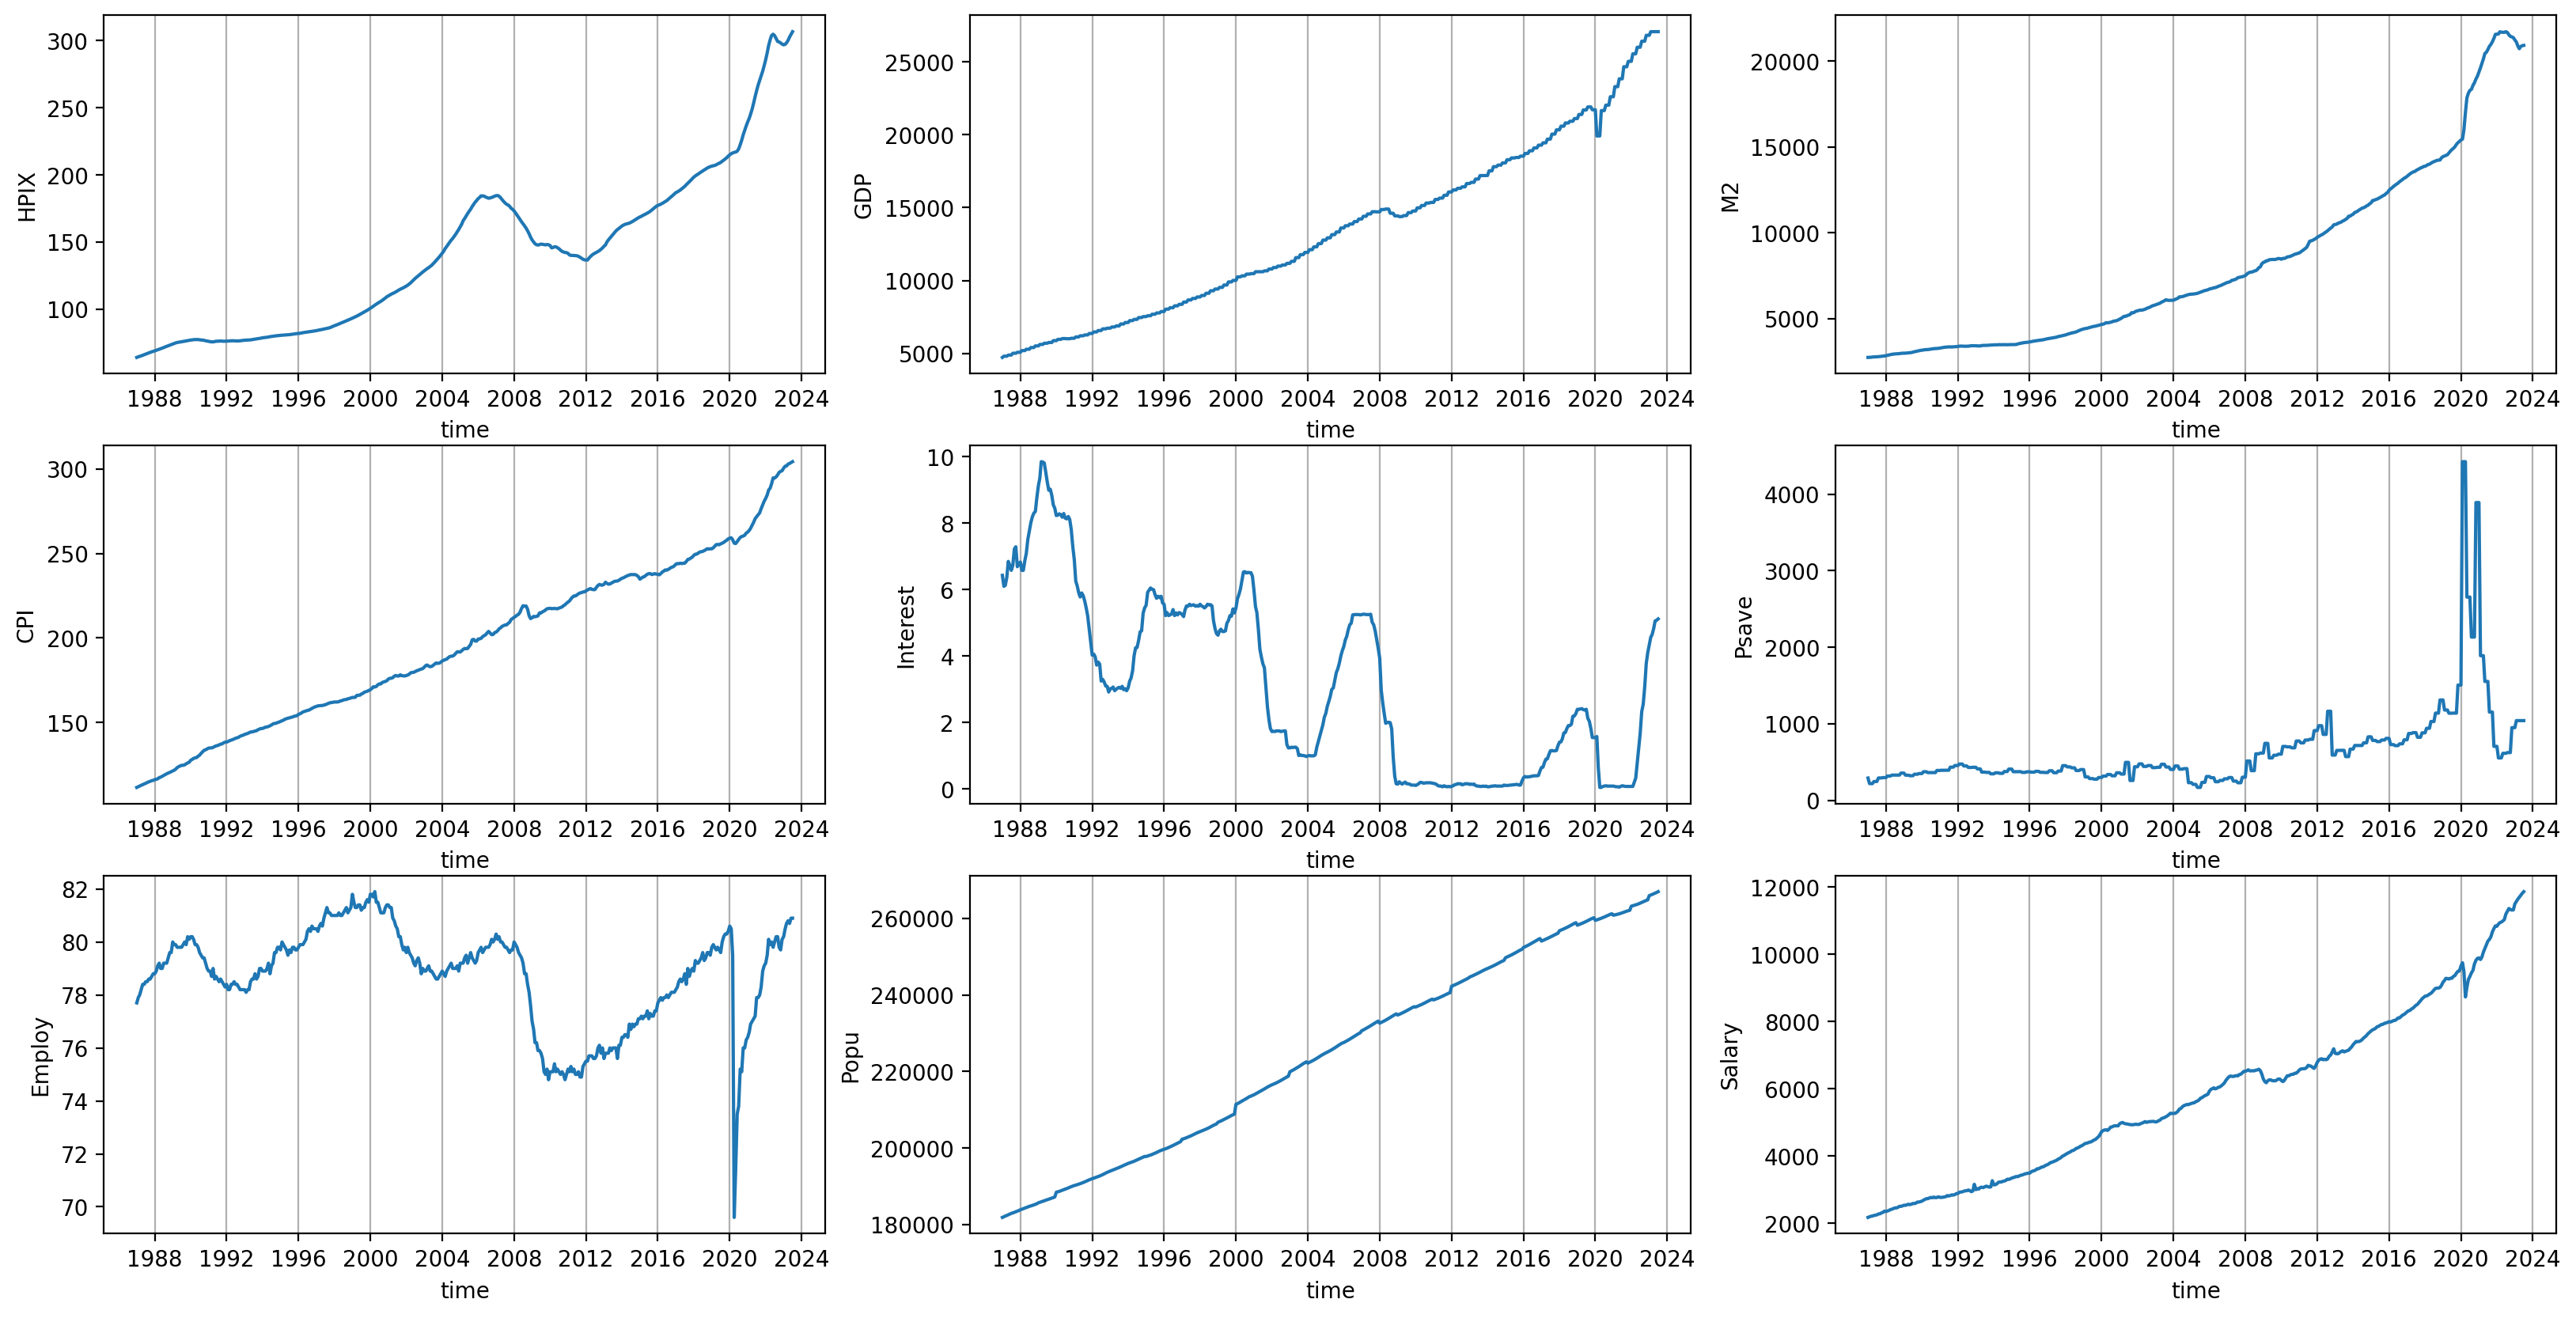

In [10]:
# target overview
plt.figure(figsize=(20,10), dpi=200)

plt.subplot(331)
plt.plot(data['date'], data['HPIX'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("HPIX", fontsize=10)

plt.subplot(332)
plt.plot(data['date'], data['GDP'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("GDP", fontsize=10)

plt.subplot(333)
plt.plot(data['date'], data['M2'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("M2", fontsize=10)

plt.subplot(334)
plt.plot(data['date'], data['CPI'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("CPI", fontsize=10)

plt.subplot(335)
plt.plot(data['date'], data['Interest'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Interest", fontsize=10)

plt.subplot(336)
plt.plot(data['date'], data['Psave'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Psave", fontsize=10)

plt.subplot(337)
plt.plot(data['date'], data['Employ'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Employ", fontsize=10)

plt.subplot(338)
plt.plot(data['date'], data['Popu'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Popu", fontsize=10)

plt.subplot(339)
plt.plot(data['date'], data['Salary'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Salary", fontsize=10)


plt.tick_params(labelsize=10)
plt.show()

---
# 3. Feature Engineering

#### Momentum effect

In [11]:
# predict on the movement, instead the target itself
for col in ['HPIX', 'GDP', 'M2', 'CPI', 'Psave', 'Popu', 'Salary', 'Nasdaq']:
    data[f"mtm_{col}"] = (data[col] - data[col].shift(1)) / data[col].shift(1)

#### average line

In [20]:
for col in ['GDP', 'M2', 'CPI', 'Psave', 'Popu', 'Salary']:
    data[f'rolratio_{col}'] = data[col] / data[col].rolling(12, min_periods=1).mean()

#### outlier handling 

In [12]:
# for the outliers
# simply cut-down
for col in ['Employ', 'GDP', 'M2', 'Popu', 'Salary', 'mtm_GDP', 'mtm_M2', 'mtm_Popu', 'mtm_Salary', 'mtm_Psave']:
    low_perc, up_perc = np.percentile(data[col], [5,95])
    data[col] = np.where(data[col] > up_perc, up_perc, data[col])
    data[col] = np.where(data[col] < low_perc, low_perc, data[col])

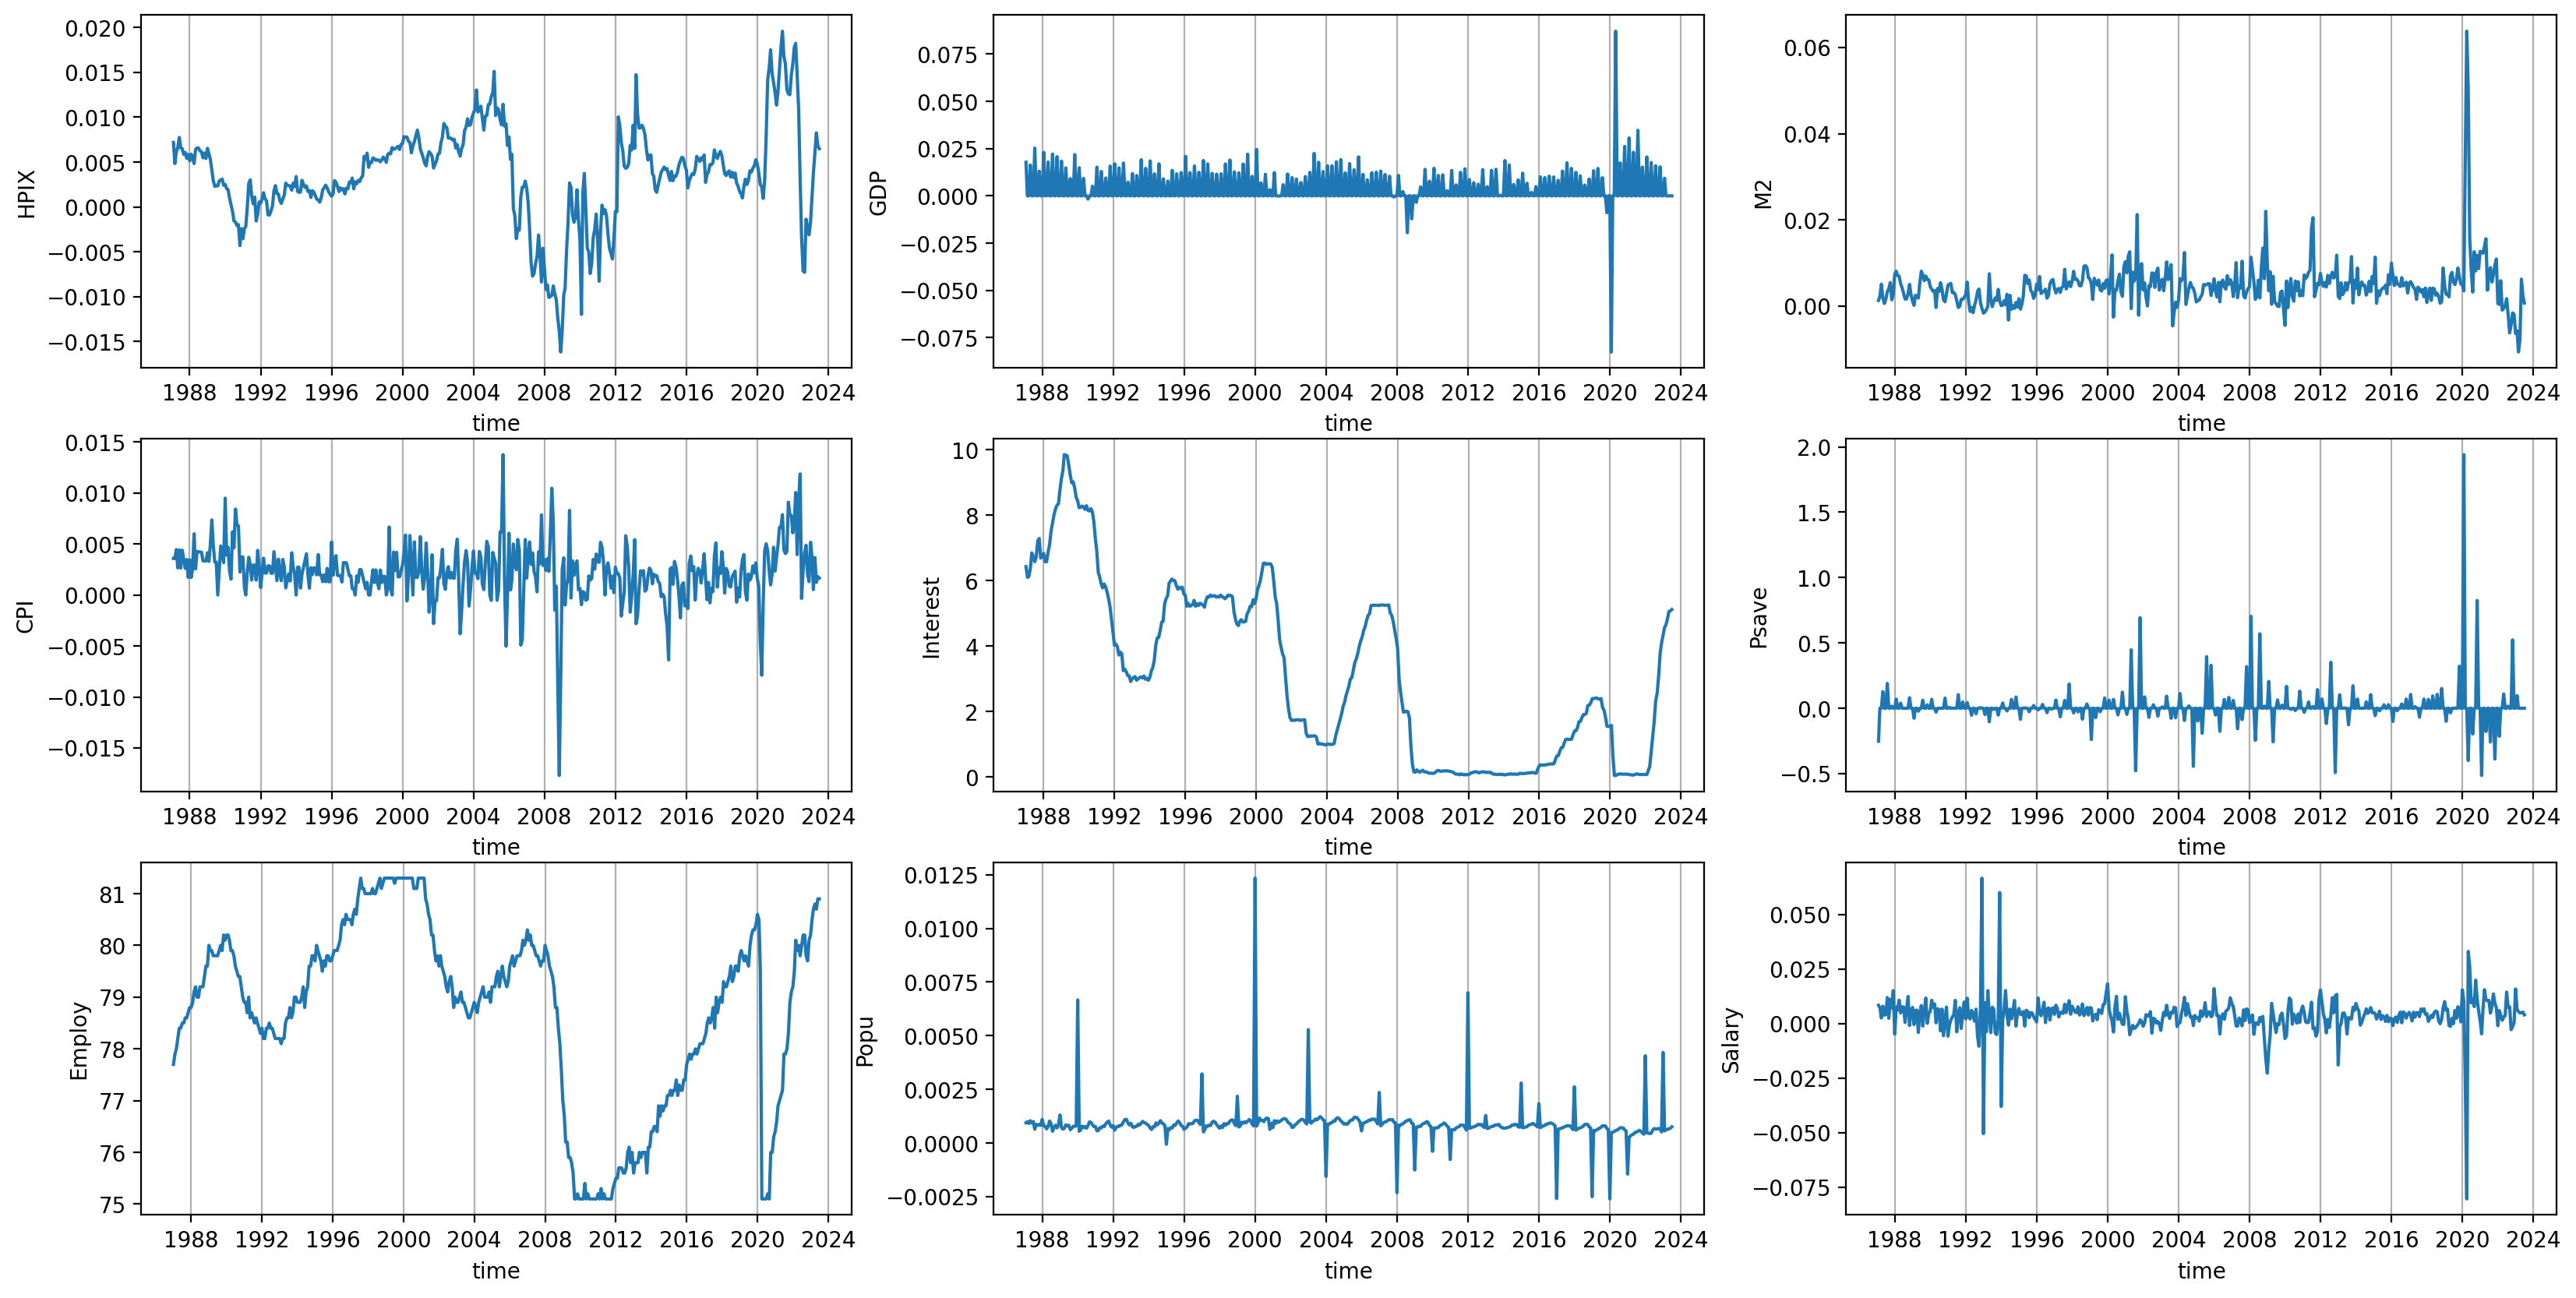

In [13]:
# target overview
plt.figure(figsize=(20,10), dpi=200)

plt.subplot(331)
plt.plot(data['date'], data['mtm_HPIX'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("HPIX", fontsize=10)

plt.subplot(332)
plt.plot(data['date'], data['mtm_GDP'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("GDP", fontsize=10)

plt.subplot(333)
plt.plot(data['date'], data['mtm_M2'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("M2", fontsize=10)

plt.subplot(334)
plt.plot(data['date'], data['mtm_CPI'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("CPI", fontsize=10)

plt.subplot(335)
plt.plot(data['date'], data['Interest'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Interest", fontsize=10)

plt.subplot(336)
plt.plot(data['date'], data['mtm_Psave'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Psave", fontsize=10)

plt.subplot(337)
plt.plot(data['date'], data['Employ'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Employ", fontsize=10)

plt.subplot(338)
plt.plot(data['date'], data['mtm_Popu'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Popu", fontsize=10)

plt.subplot(339)
plt.plot(data['date'], data['mtm_Salary'])
plt.grid(axis='x')
plt.xlabel("time", fontsize=10)
plt.ylabel("Salary", fontsize=10)


plt.tick_params(labelsize=10)
plt.show()

In [21]:
data = data.iloc[1:].reset_index(drop=True)
data.head()

,date,HPIX,GDP,M2,CPI,Interest,Psave,Employ,Popu,Salary,...,mtm_Psave,mtm_Popu,mtm_Salary,mtm_Nasdaq,rolratio_GDP,rolratio_M2,rolratio_CPI,rolratio_Psave,rolratio_Popu,rolratio_Salary
0,1987-04-01,65.132,5500.0786,2978.71,112.7,6.37,216.931,78.2,185231.0,2504.88,...,0.000000,0.000906,0.002580,0.010450,1.0,1.0,1.002223,1.000000,1.0,1.0
1,1987-05-01,65.563,5500.0786,2978.71,113.0,6.85,244.481,78.4,185231.0,2504.88,...,0.126999,0.001037,0.007990,-0.023112,1.0,1.0,1.003255,1.081227,1.0,1.0
2,1987-06-01,66.071,5500.0786,2978.71,113.5,6.73,244.481,78.4,185231.0,2504.88,...,0.000000,0.000931,0.003896,-0.008197,1.0,1.0,1.005760,1.059708,1.0,1.0
3,1987-07-01,66.507,5500.0786,2978.71,113.8,6.58,244.481,78.5,185231.0,2504.88,...,0.000000,0.000996,0.004193,0.022771,1.0,1.0,1.006723,1.047203,1.0,1.0
4,1987-08-01,66.938,5500.0786,2978.71,114.3,6.73,290.912,78.5,185231.0,2504.88,...,0.189917,0.000640,0.011950,0.020426,1.0,1.0,1.009272,1.196991,1.0,1.0


In [22]:
data.columns

Index(['date', 'HPIX', 'GDP', 'M2', 'CPI', 'Interest', 'Psave', 'Employ',
       'Popu', 'Salary', 'Nasdaq', 'mtm_HPIX', 'mtm_GDP', 'mtm_M2', 'mtm_CPI',
       'mtm_Psave', 'mtm_Popu', 'mtm_Salary', 'mtm_Nasdaq', 'rolratio_GDP',
       'rolratio_M2', 'rolratio_CPI', 'rolratio_Psave', 'rolratio_Popu',
       'rolratio_Salary'],
      dtype='object')

#### Some other features like:
- Cross terms in the regression model
- Sometimes realization factors overplays expectation factors.
- Upstream or downstream indexes, such as building material and furniture prices.
- Other factors as market sentiment or government land policy.

*Due to time limit, not implemented.*

----
# 4. Model Selection

- **Baseline**: ARIMA
- **Improved**: 
    - OLS & Lasso
    - Xgboost

### ARIMA: data pre-process

#### ARMA requires the hypothesis that the time-series is stationary
#### tested by ADF test

In [44]:
# ADF test on original time series Home price Index
print(tsat.adfuller(data['HPIX']))
# ADF test on the first-order of time series Home price Index
print(tsat.adfuller(data['mtm_HPIX']))

(1.014348659714905, 0.9944150600035891, 18, 417, {'1%': -3.446129402876608, '5%': -2.8684960761128346, '10%': -2.570475362616382}, 228.36001000572344)
(-2.955316220668871, 0.039283289700147585, 13, 422, {'1%': -3.44594128742536, '5%': -2.868413360220551, '10%': -2.570431271085555}, -4098.829611340794)


After the first-order transformation(in other words we are predicting the momentum of the HPIX), the time-series is stationary on the 5% confidence level, given by ADF test.

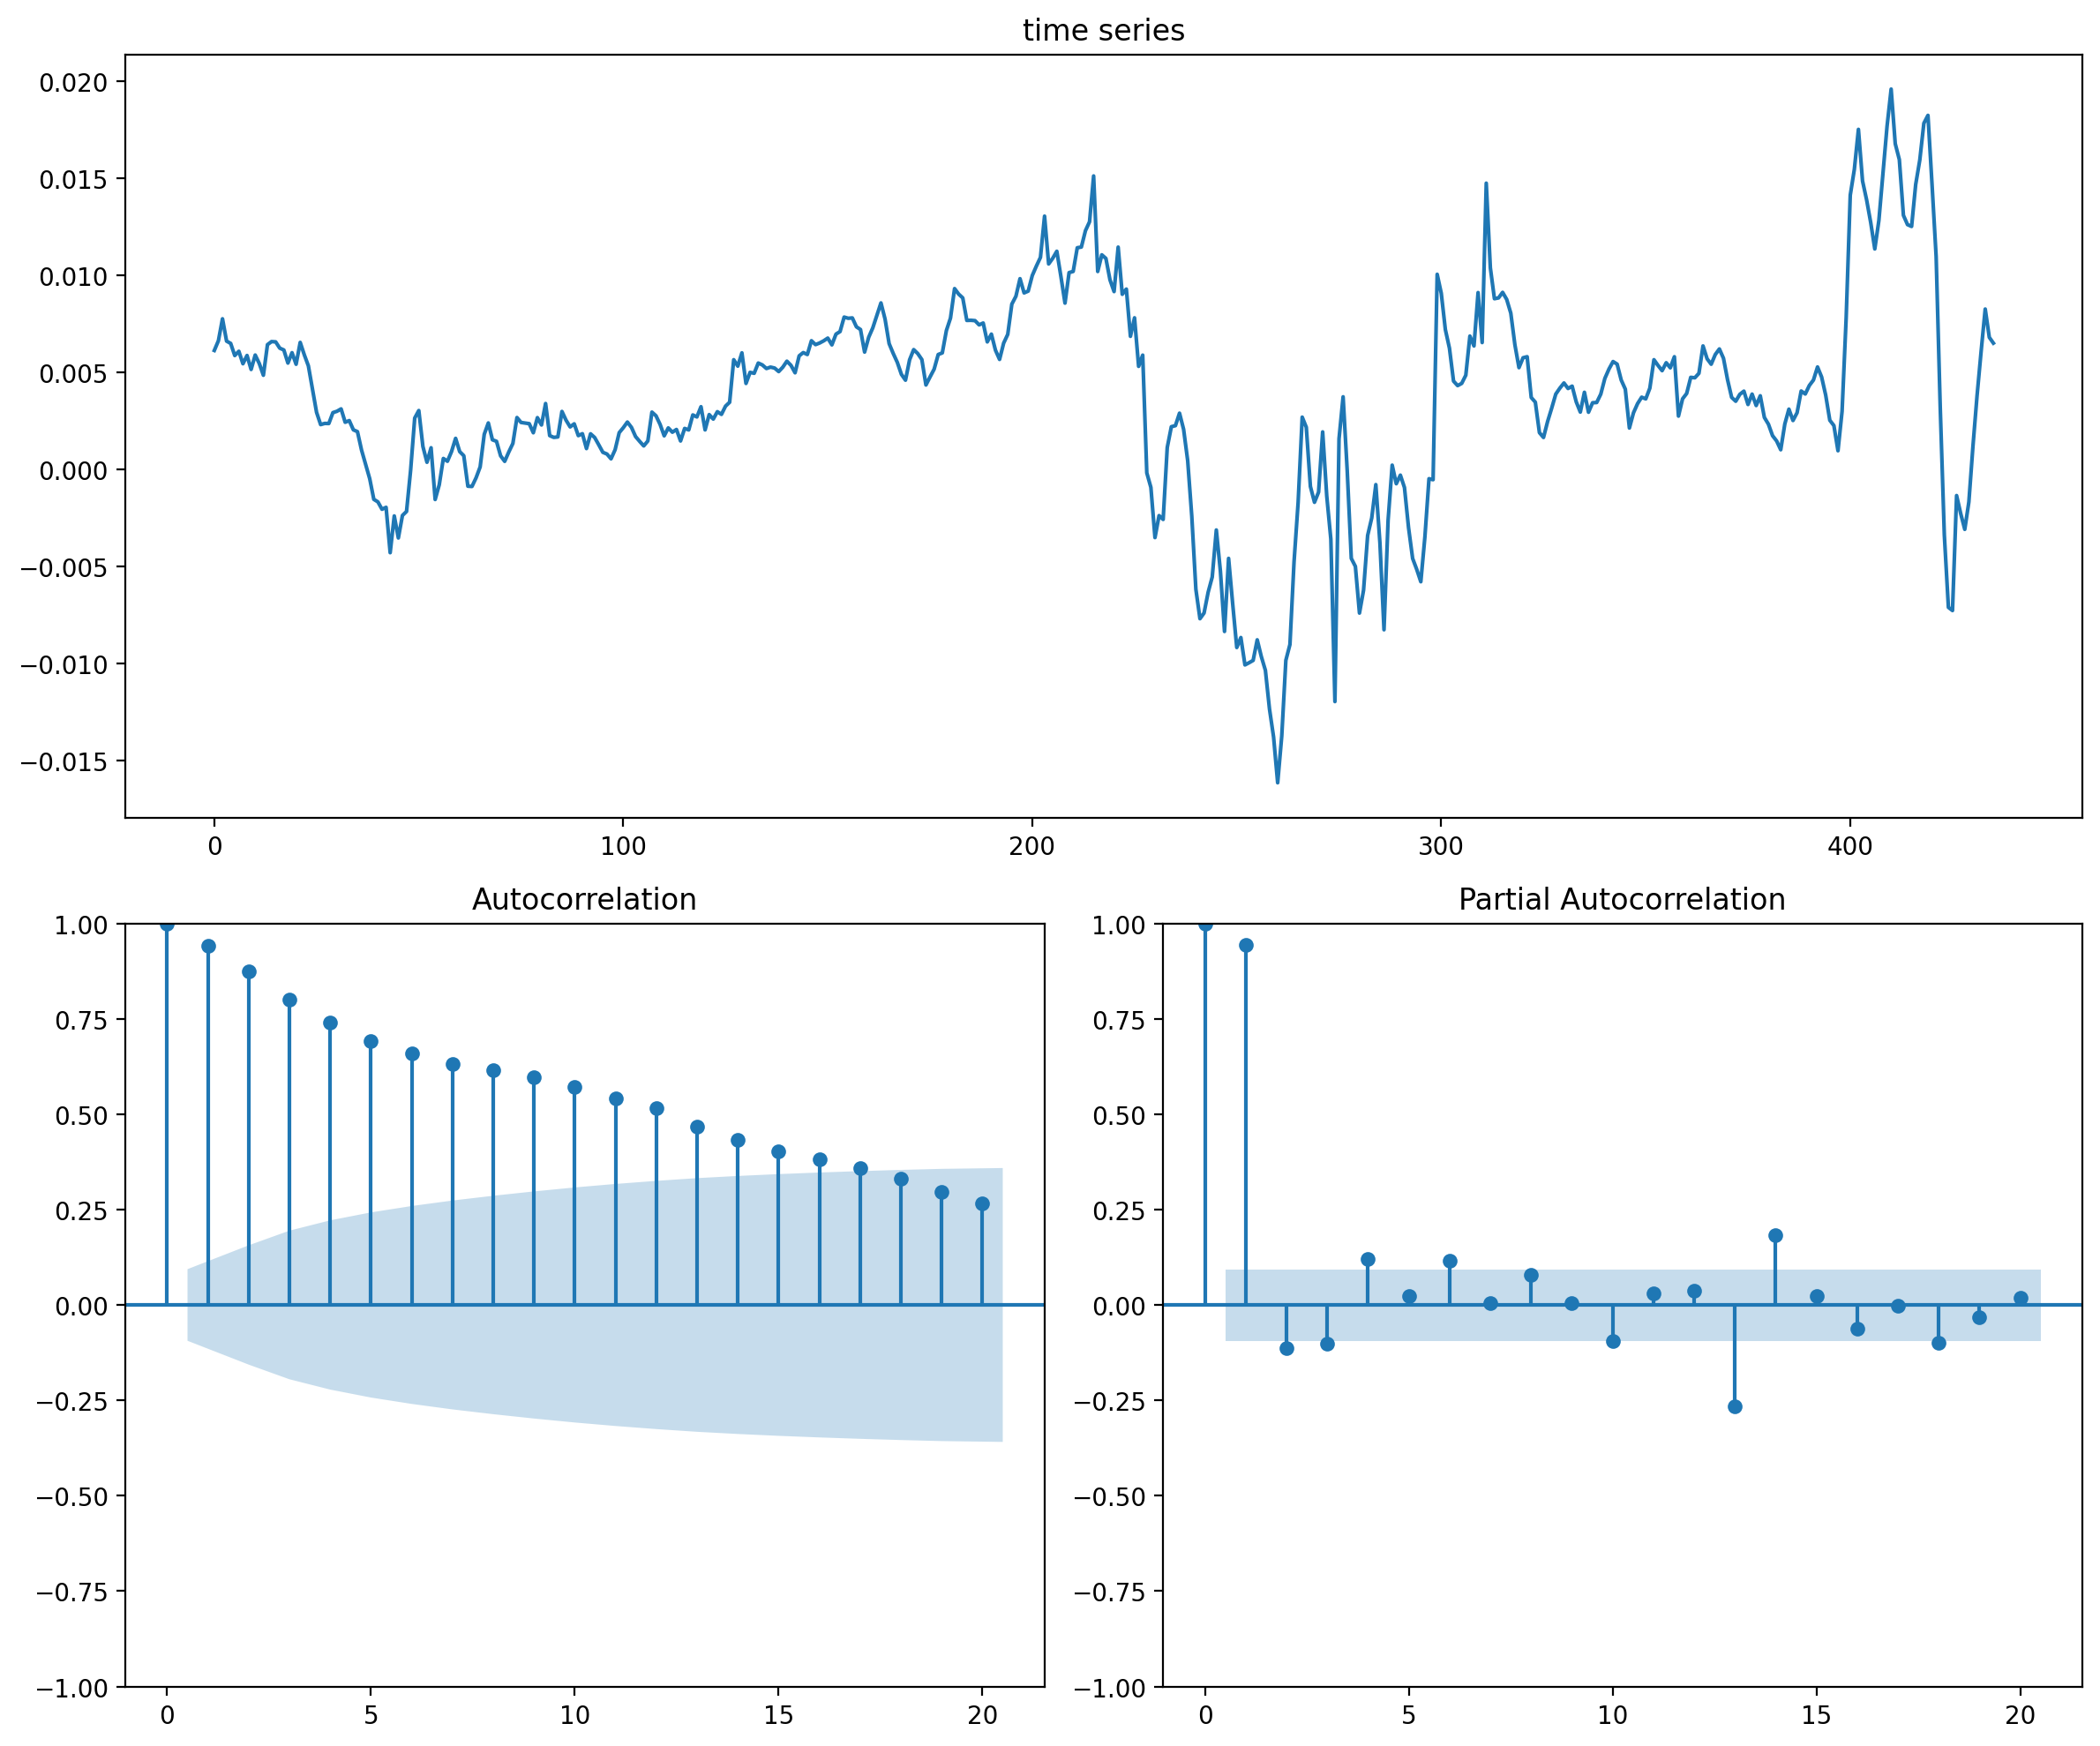

In [48]:
# ACF & PACF Plot
def plotds(xt, nlag=10):
    plt.figure(figsize=(12,10), dpi=200)
    layout = (2,2)
    ax_xt = plt.subplot2grid(layout, (0,0), colspan=2)
    ax_acf = plt.subplot2grid(layout, (1,0))
    ax_pacf = plt.subplot2grid(layout, (1,1))
    
    xt.plot(ax=ax_xt)
    ax_xt.set_title('time series')
    plot_acf(xt, lags=nlag, ax=ax_acf)
    plot_pacf(xt, lags=nlag, ax=ax_pacf)
    plt.tight_layout()
    
    plt.show()

plotds(data['mtm_HPIX'], nlag=20)

Notice that the auto-correlation graph is thick-tailed, while partial auto-correlation decay very fast. Which tells us ARIMA model will be better than simple ARMA model.

#### Grid search for the order parameter in ARIMA model

In [59]:
data_new = data['mtm_HPIX'].copy()

aic_value = []
for ari in range(1,5):
    for arj in range(1,5):
        arma_ij = ARIMA(data_new.values.tolist(), order=(ari,0,arj)).fit()
        aic_value.append([ari, arj, arma_ij.aic])
        
aic_value.sort(key=lambda x:x[2])
aic_value[0]

[4, 3, -4266.519840726124]

**Parameter of Order in ARIMA**: (4,3)

### OLS: data pre-process

#### OLS makes basic hypothesis about the multicolinearity in the X dataset
- Need to be satisfied if we want to test hypothesis over coefficients.
- Is considered not to be that important if we want to get the inference and evalutaion.

Since we also want to test the stability of coefficients over time, we need an independent X set.
- PCA method is ususally stable over a larger dataset, which means on our own dataset, if we want to conduct stability analysis, we shall not use PCA for dimension reduction while excluding look-ahead problem.
- Hence for time-rolling training-prediction mechanism we choose Lasso Regression, which can eliminate the effect of multicolinearity.

In [63]:
data.drop(columns=['date', 'HPIX', 'mtm_HPIX']).corr()

,GDP,M2,CPI,Interest,Psave,Employ,Popu,Salary,Nasdaq,mtm_GDP,...,mtm_Psave,mtm_Popu,mtm_Salary,mtm_Nasdaq,rolratio_GDP,rolratio_M2,rolratio_CPI,rolratio_Psave,rolratio_Popu,rolratio_Salary
GDP,1.000000,0.968072,0.991055,-0.703755,0.583800,-0.324164,0.984317,0.998258,0.877781,-0.021482,...,0.027444,-0.113046,-0.007424,0.010733,-0.060990,0.340630,-0.024994,-0.006007,-0.283780,-0.058483
M2,0.968072,1.000000,0.944874,-0.620685,0.647622,-0.302605,0.917575,0.966736,0.946332,0.000868,...,0.023125,-0.125107,0.010797,0.015571,-0.076279,0.326507,0.079982,-0.019757,-0.405272,-0.084859
CPI,0.991055,0.944874,1.000000,-0.732193,0.557375,-0.344218,0.986254,0.988992,0.838070,-0.048853,...,0.040048,-0.102363,-0.029388,0.007403,-0.089408,0.331217,-0.048473,0.020507,-0.239631,-0.078255
Interest,-0.703755,-0.620685,-0.732193,1.000000,-0.445498,0.686254,-0.775045,-0.692140,-0.449447,0.024622,...,0.008503,0.092686,0.084334,-0.020096,0.003698,-0.375878,0.346165,0.062286,0.060996,0.150957
Psave,0.583800,0.647622,0.557375,-0.445498,1.000000,-0.358603,0.573746,0.597793,0.619686,-0.082926,...,0.253111,-0.158271,-0.104256,0.045047,-0.189721,0.589569,-0.165696,0.402947,-0.302568,-0.074462
Employ,-0.324164,-0.302605,-0.344218,0.686254,-0.358603,1.000000,-0.396701,-0.291005,-0.088196,-0.048814,...,0.055029,0.097004,0.085177,-0.049895,0.068505,-0.290756,0.315547,0.024350,0.153159,0.305394
Popu,0.984317,0.917575,0.986254,-0.775045,0.573746,-0.396701,1.000000,0.981995,0.792620,-0.048853,...,0.040089,-0.104521,-0.038749,0.008127,-0.080627,0.380916,-0.136303,0.029557,-0.194012,-0.073617
Salary,0.998258,0.966736,0.988992,-0.692140,0.597793,-0.291005,0.981995,1.000000,0.885465,-0.041665,...,0.045699,-0.110710,-0.008096,0.004816,-0.078110,0.353497,-0.022039,0.015164,-0.275810,-0.049372
Nasdaq,0.877781,0.946332,0.838070,-0.449447,0.619686,-0.088196,0.792620,0.885465,1.000000,0.019153,...,0.008604,-0.097332,0.064362,0.045953,0.037503,0.307501,0.226100,-0.090168,-0.379848,0.060634
mtm_GDP,-0.021482,0.000868,-0.048853,0.024622,-0.082926,-0.048814,-0.048853,-0.041665,0.019153,1.000000,...,-0.380793,-0.040906,0.089870,0.088222,0.418285,0.122261,0.019308,-0.265090,-0.027626,-0.033163


---
# 5. Model Training and Validation

There are 2 different train-test split method usually used in financial prediction:
- **Time-split**: use the first 80% time for as training set and the remaining 20% as testing & Validation Set.
- **Time-Rolling /Prediction**: To capture the short-term market style and avoid high delay, we can update our model at a fixed frequency. For example, Every 3 years, we train a new model with the data of the past 3 years and make predict ion on the following 6 months. After all the training & prediction, we merge all the inference and make evaluation together.

The second method is more common in high-frequency prediction due to the limit of dataset. 

On our task we mainly use the naive time-split method, and explore the second method for trial.

### 5.0 Time-Split

In [68]:
# features
features = [
    'GDP', 'M2', 'CPI', 'Interest', 'Psave', 'Employ', 'Popu', 'Salary',
    'Nasdaq', 'mtm_GDP', 'mtm_M2', 'mtm_CPI', 'mtm_Psave', 'mtm_Popu',
    'mtm_Salary', 'mtm_Nasdaq', 'rolratio_GDP', 'rolratio_M2', 'rolratio_CPI',
    'rolratio_Psave', 'rolratio_Popu', 'rolratio_Salary'
]

In [73]:
# time split
split_ix = int(0.8 * data.shape[0])

train_x = data.loc[:split_ix][features]
test_x = data.loc[split_ix+1:][features]
train_y = data.loc[:split_ix]['mtm_HPIX']
test_y = data.loc[split_ix+1:]['mtm_HPIX']

### 5.1 time-rolling prediction framework

In [116]:
# training and predicting batch size
train_batch_size, test_batch_size = 36, 6
batch_size = train_batch_size + test_batch_size
batches = data.shape[0] // batch_size

# batched data
batch_data = []
for i in range(batches):
    train_x_batch = data.loc[i*batch_size: i*batch_size+train_batch_size-1][features]
    train_y_batch = data.loc[i*batch_size: i*batch_size+train_batch_size-1]['mtm_HPIX']
    test_x_batch = data.loc[i*batch_size+train_batch_size: (i+1)*batch_size-1][features]
    test_y_batch = data.loc[i*batch_size+train_batch_size: (i+1)*batch_size-1]['mtm_HPIX']
    assert train_x_batch.shape[0] == train_batch_size
    assert test_x_batch.shape[0] == test_batch_size
    batch_data.append((train_x_batch, train_y_batch, test_x_batch, test_y_batch))

### 5.2.1 ARIMA model

#### Time-split method

In [214]:
ARIMA_split1_model = ARIMA(train_y.values.tolist(), order=(4,0,3)).fit()
ARIMA_split1_inference = ARIMA_split1_model.forecast(test_y.shape[0])

### 5.2.2 Lasso Regression
#### Time-split method

In [106]:
LASSO_split1_model = linear_model.Lasso(alpha=0.1).fit(train_x, train_y)
LASSO_split1_inference = LASSO_split1_model.predict(test_x)

#### Rolling spliting method

In [314]:
# coeffients
coefs = []
inf_dates = []
test_y_real, test_y_infer = np.array([]), np.array([])
for train_x_batch, train_y_batch, test_x_batch, test_y_batch in batch_data:
    LASSO_split2_model = linear_model.Lasso(alpha=0.1).fit(train_x_batch, train_y_batch)
    LASSO_split2_inference = LASSO_split2_model.predict(test_x_batch)
    coefs.append(LASSO_split2_model.coef_)
    inf_dates.append(data.loc[test_x_batch.index]['date'].values)
    
    test_y_real = np.hstack([test_y_real, test_y_batch])
    test_y_infer = np.hstack([test_y_infer, LASSO_split2_inference])

LASSO_split2_inference = pd.DataFrame()
LASSO_split2_inference['real'] = test_y_real
LASSO_split2_inference['predict'] = test_y_infer
LASSO_split2_inference.index = np.hstack(inf_dates)
LASSO_split2_inference.head()

,real,predict
1990-04-01,0.000984,0.000989
1990-05-01,0.000246,0.000806
1990-06-01,-0.000492,0.000609
1990-07-01,-0.001553,0.000432
1990-08-01,-0.001685,0.000223


### 5.2.3 XGBoost

In [217]:
# time-split method
XGB_split1_model = xgb.XGBRegressor(
    booster='gbtree',
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=100,
    learning_rate=0.08,
    subsample=0.75,
    colsample_bytree=1, 
    max_depth=5,
    gamma=0,
)
XGB_split1_model.fit(train_x, train_y, eval_set=[(train_x, train_y),(test_x, test_y)], verbose=1)
XGB_split1_inference = XGB_split1_model.predict(test_x)

[0]	validation_0-rmse:0.45748	validation_1-rmse:0.45418
[1]	validation_0-rmse:0.42102	validation_1-rmse:0.41772
[2]	validation_0-rmse:0.38748	validation_1-rmse:0.38418
[3]	validation_0-rmse:0.35659	validation_1-rmse:0.35329
[4]	validation_0-rmse:0.32819	validation_1-rmse:0.32489
[5]	validation_0-rmse:0.30204	validation_1-rmse:0.29874
[6]	validation_0-rmse:0.27798	validation_1-rmse:0.27468
[7]	validation_0-rmse:0.25584	validation_1-rmse:0.25254
[8]	validation_0-rmse:0.23545	validation_1-rmse:0.23216
[9]	validation_0-rmse:0.21669	validation_1-rmse:0.21339
[10]	validation_0-rmse:0.19943	validation_1-rmse:0.19614
[11]	validation_0-rmse:0.18355	validation_1-rmse:0.18025
[12]	validation_0-rmse:0.16894	validation_1-rmse:0.16565
[13]	validation_0-rmse:0.15548	validation_1-rmse:0.15219
[14]	validation_0-rmse:0.14309	validation_1-rmse:0.13980
[15]	validation_0-rmse:0.13169	validation_1-rmse:0.12841
[16]	validation_0-rmse:0.12118	validation_1-rmse:0.11790
[17]	validation_0-rmse:0.11153	validation

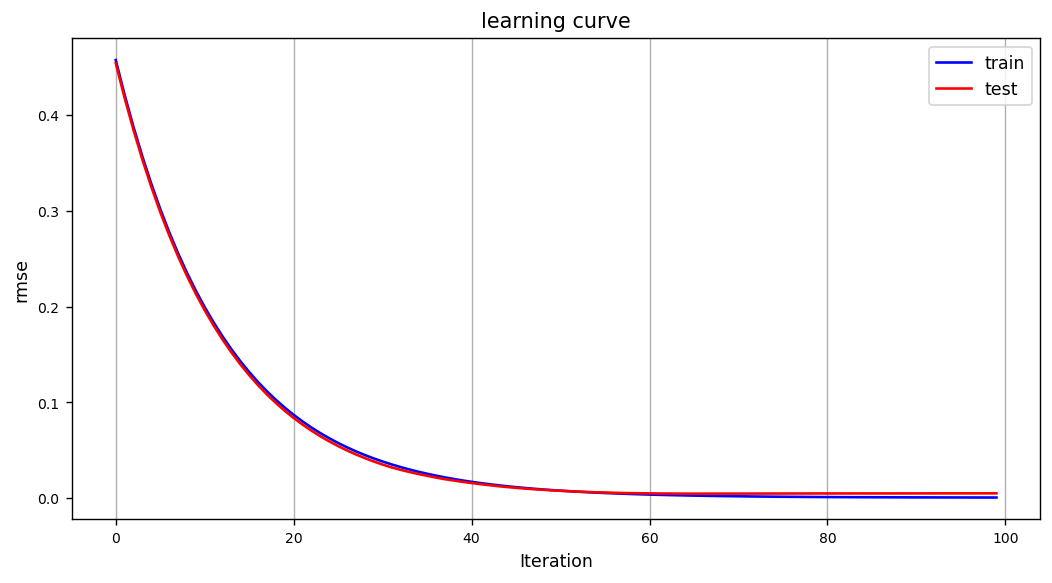

In [218]:
# learning curve
plt.figure(figsize=(10,5), dpi=125)

plt.plot(XGB_split1_model.evals_result()['validation_0']['rmse'], 'b-', label='train')
plt.plot(XGB_split1_model.evals_result()['validation_1']['rmse'], 'r-', label='test')

plt.legend(fontsize=10)
plt.grid(axis='x')
plt.xlabel("Iteration", fontsize=10)
plt.ylabel("rmse", fontsize=10)
plt.tick_params(labelsize=8)
plt.title('learning curve', fontsize=12)

plt.show()

---
# 6. Evaluation

- **General metrics**: RMSE, IS/OOS $R^2$, Pearson/Spearman Correlation
- **Other metrics**: Stratification monotonicity and variance, time-rolling parameter stability

#### overview

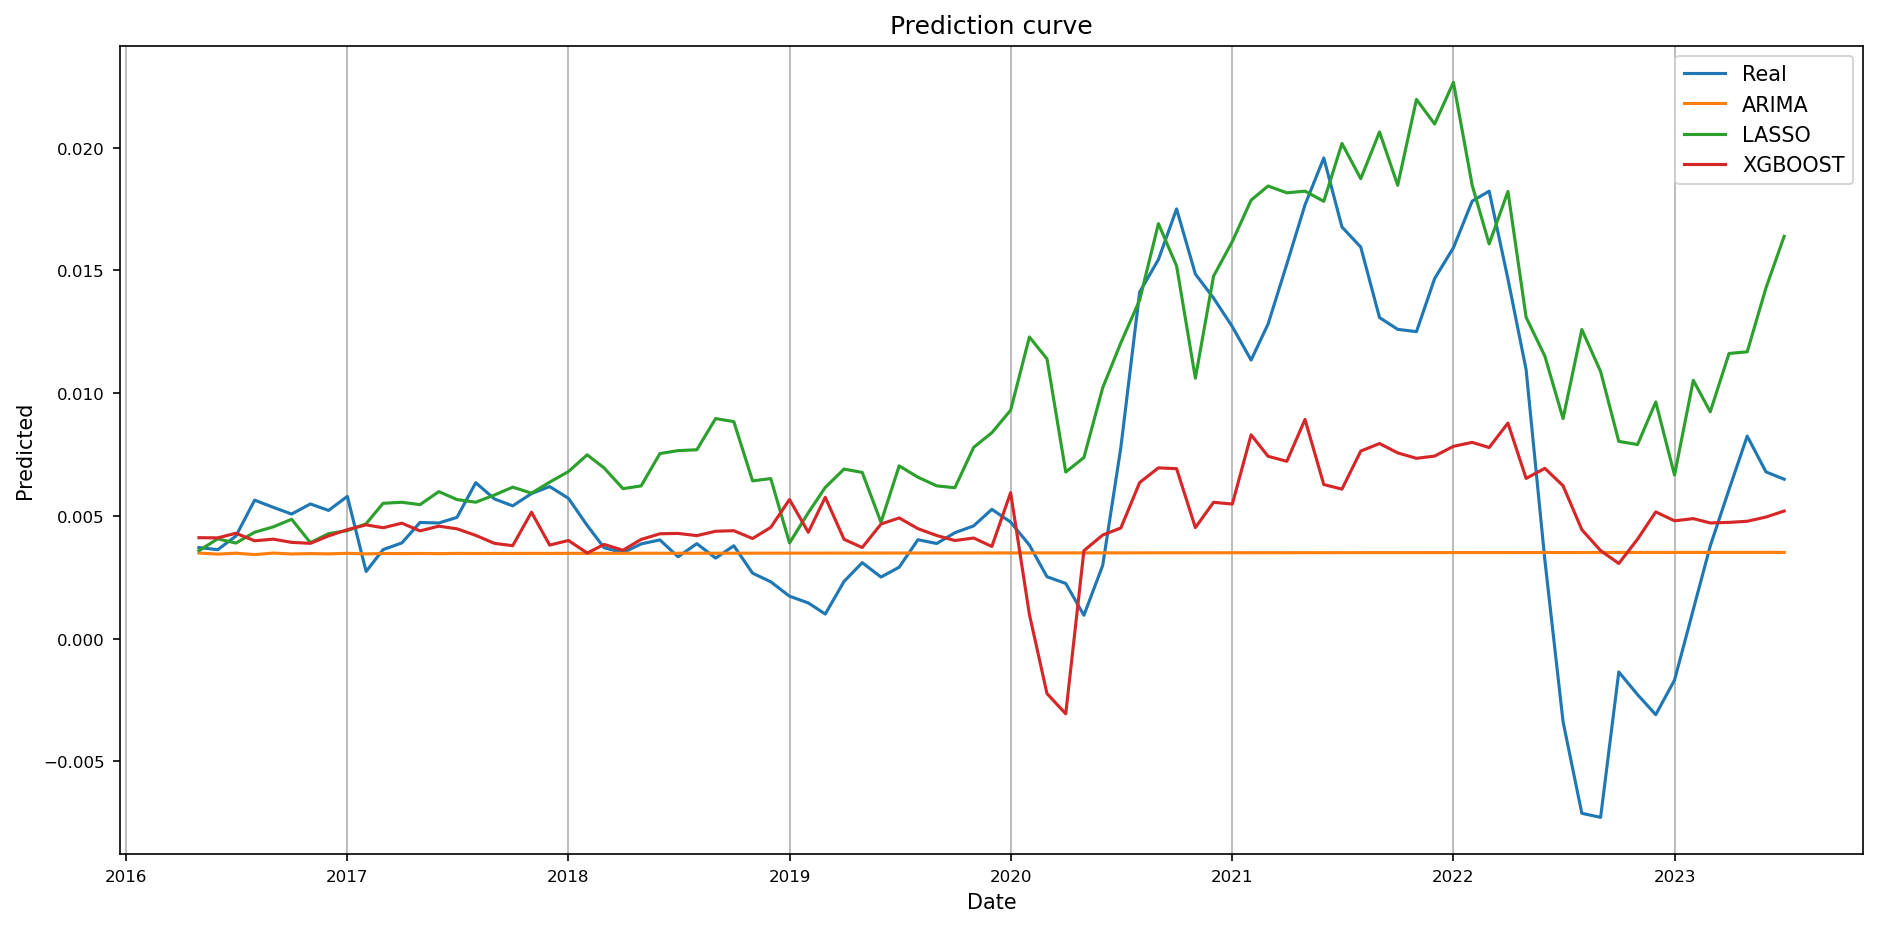

In [221]:
# prediction curve
inference_dates = data.loc[test_x.index]['date']
plt.figure(figsize=(15,7), dpi=150)

plt.plot(inference_dates, test_y, label='Real')
plt.plot(inference_dates, ARIMA_split1_inference, label='ARIMA')
plt.plot(inference_dates, LASSO_split1_inference, label='LASSO')
plt.plot(inference_dates, XGB_split1_inference, label='XGBOOST')

plt.legend(fontsize=10, loc='best')
plt.grid(axis='x')
plt.xlabel("Date", fontsize=10)
plt.ylabel("Predicted", fontsize=10)
plt.tick_params(labelsize=8)
plt.title('Prediction curve', fontsize=12)

plt.show()

From the visual point of view,
- ARIMA predicts the average target and lacks variance.
- Both LASSO & XGBoost can capture some movement tendency in HPIX, but there is obvious strong lag in the prediction.
- Both models inherit the feature of the significantly positive mean on the training set, so there is a **significant positive bias** after the data distribution transition of the training and test sets.

#### General Metrics

In [294]:
# RMSE
RMSE = [
    np.sqrt(mean_squared_error(y_true=test_y, y_pred=ARIMA_split1_inference)),
    np.sqrt(mean_squared_error(y_true=test_y, y_pred=LASSO_split1_inference)),
    np.sqrt(mean_squared_error(y_true=test_y, y_pred=XGB_split1_inference))
]

# Out-of-sample R^2
R2 = [
    r2_score(y_true=test_y, y_pred=ARIMA_split1_inference),
    r2_score(y_true=test_y, y_pred=LASSO_split1_inference),
    r2_score(y_true=test_y, y_pred=XGB_split1_inference)
]

# Pearson correlation
pearson = [
    pearsonr(test_y, ARIMA_split1_inference)[0],
    pearsonr(test_y, LASSO_split1_inference)[0],
    pearsonr(test_y, XGB_split1_inference)[0]
]

# spearman correlation
spearman = [
    spearmanr(test_y, ARIMA_split1_inference)[0],
    spearmanr(test_y, LASSO_split1_inference)[0],
    spearmanr(test_y, XGB_split1_inference)[0]
]

In [295]:
general_eval = pd.DataFrame()
general_eval['RMSE'] = RMSE
general_eval['R2'] = R2
general_eval['Pearson'] = pearson
general_eval['Spearman'] = spearman
general_eval.index = ['Baseline: ARIMA', 'LASSO', 'XGBoost']
for col in general_eval.columns:
    general_eval[col] = general_eval[col].apply(lambda x: '%.3g'%x)
general_eval

,RMSE,R2,Pearson,Spearman
Baseline: ARIMA,0.0064,-0.225,0.204,0.141
LASSO,0.00561,0.0585,0.718,0.503
XGBoost,0.00505,0.238,0.612,0.527


#### Stratification monotonicity and variance

- If we match each pair of real target with the predicted target,
- split the pairs into n quantiles based on the predicted value. 
- As the increase of the quantile we expect the real target within the quantile group to increase monotonously and steadily,
- which can be reflected through the monotonicity and variance of the quantile.

In [264]:
def box_plot(groupedOutput, ax, name):
    ax.boxplot(
        groupedOutput,
        medianprops={
            'color': 'red',
            'linewidth': '1.5'
        },
        meanline=True,
        showmeans=True,
        meanprops={
            'color': 'blue',
            'ls': '--',
            'linewidth': '1.5'
        },
        flierprops={
            "marker": "o",
            "markerfacecolor": "red",
            "markersize": 1
        },
    )

    plt.grid(axis='x')
    plt.xlabel("Group", fontsize=10)
    plt.ylabel("Real value", fontsize=10)
    plt.tick_params(labelsize=8)

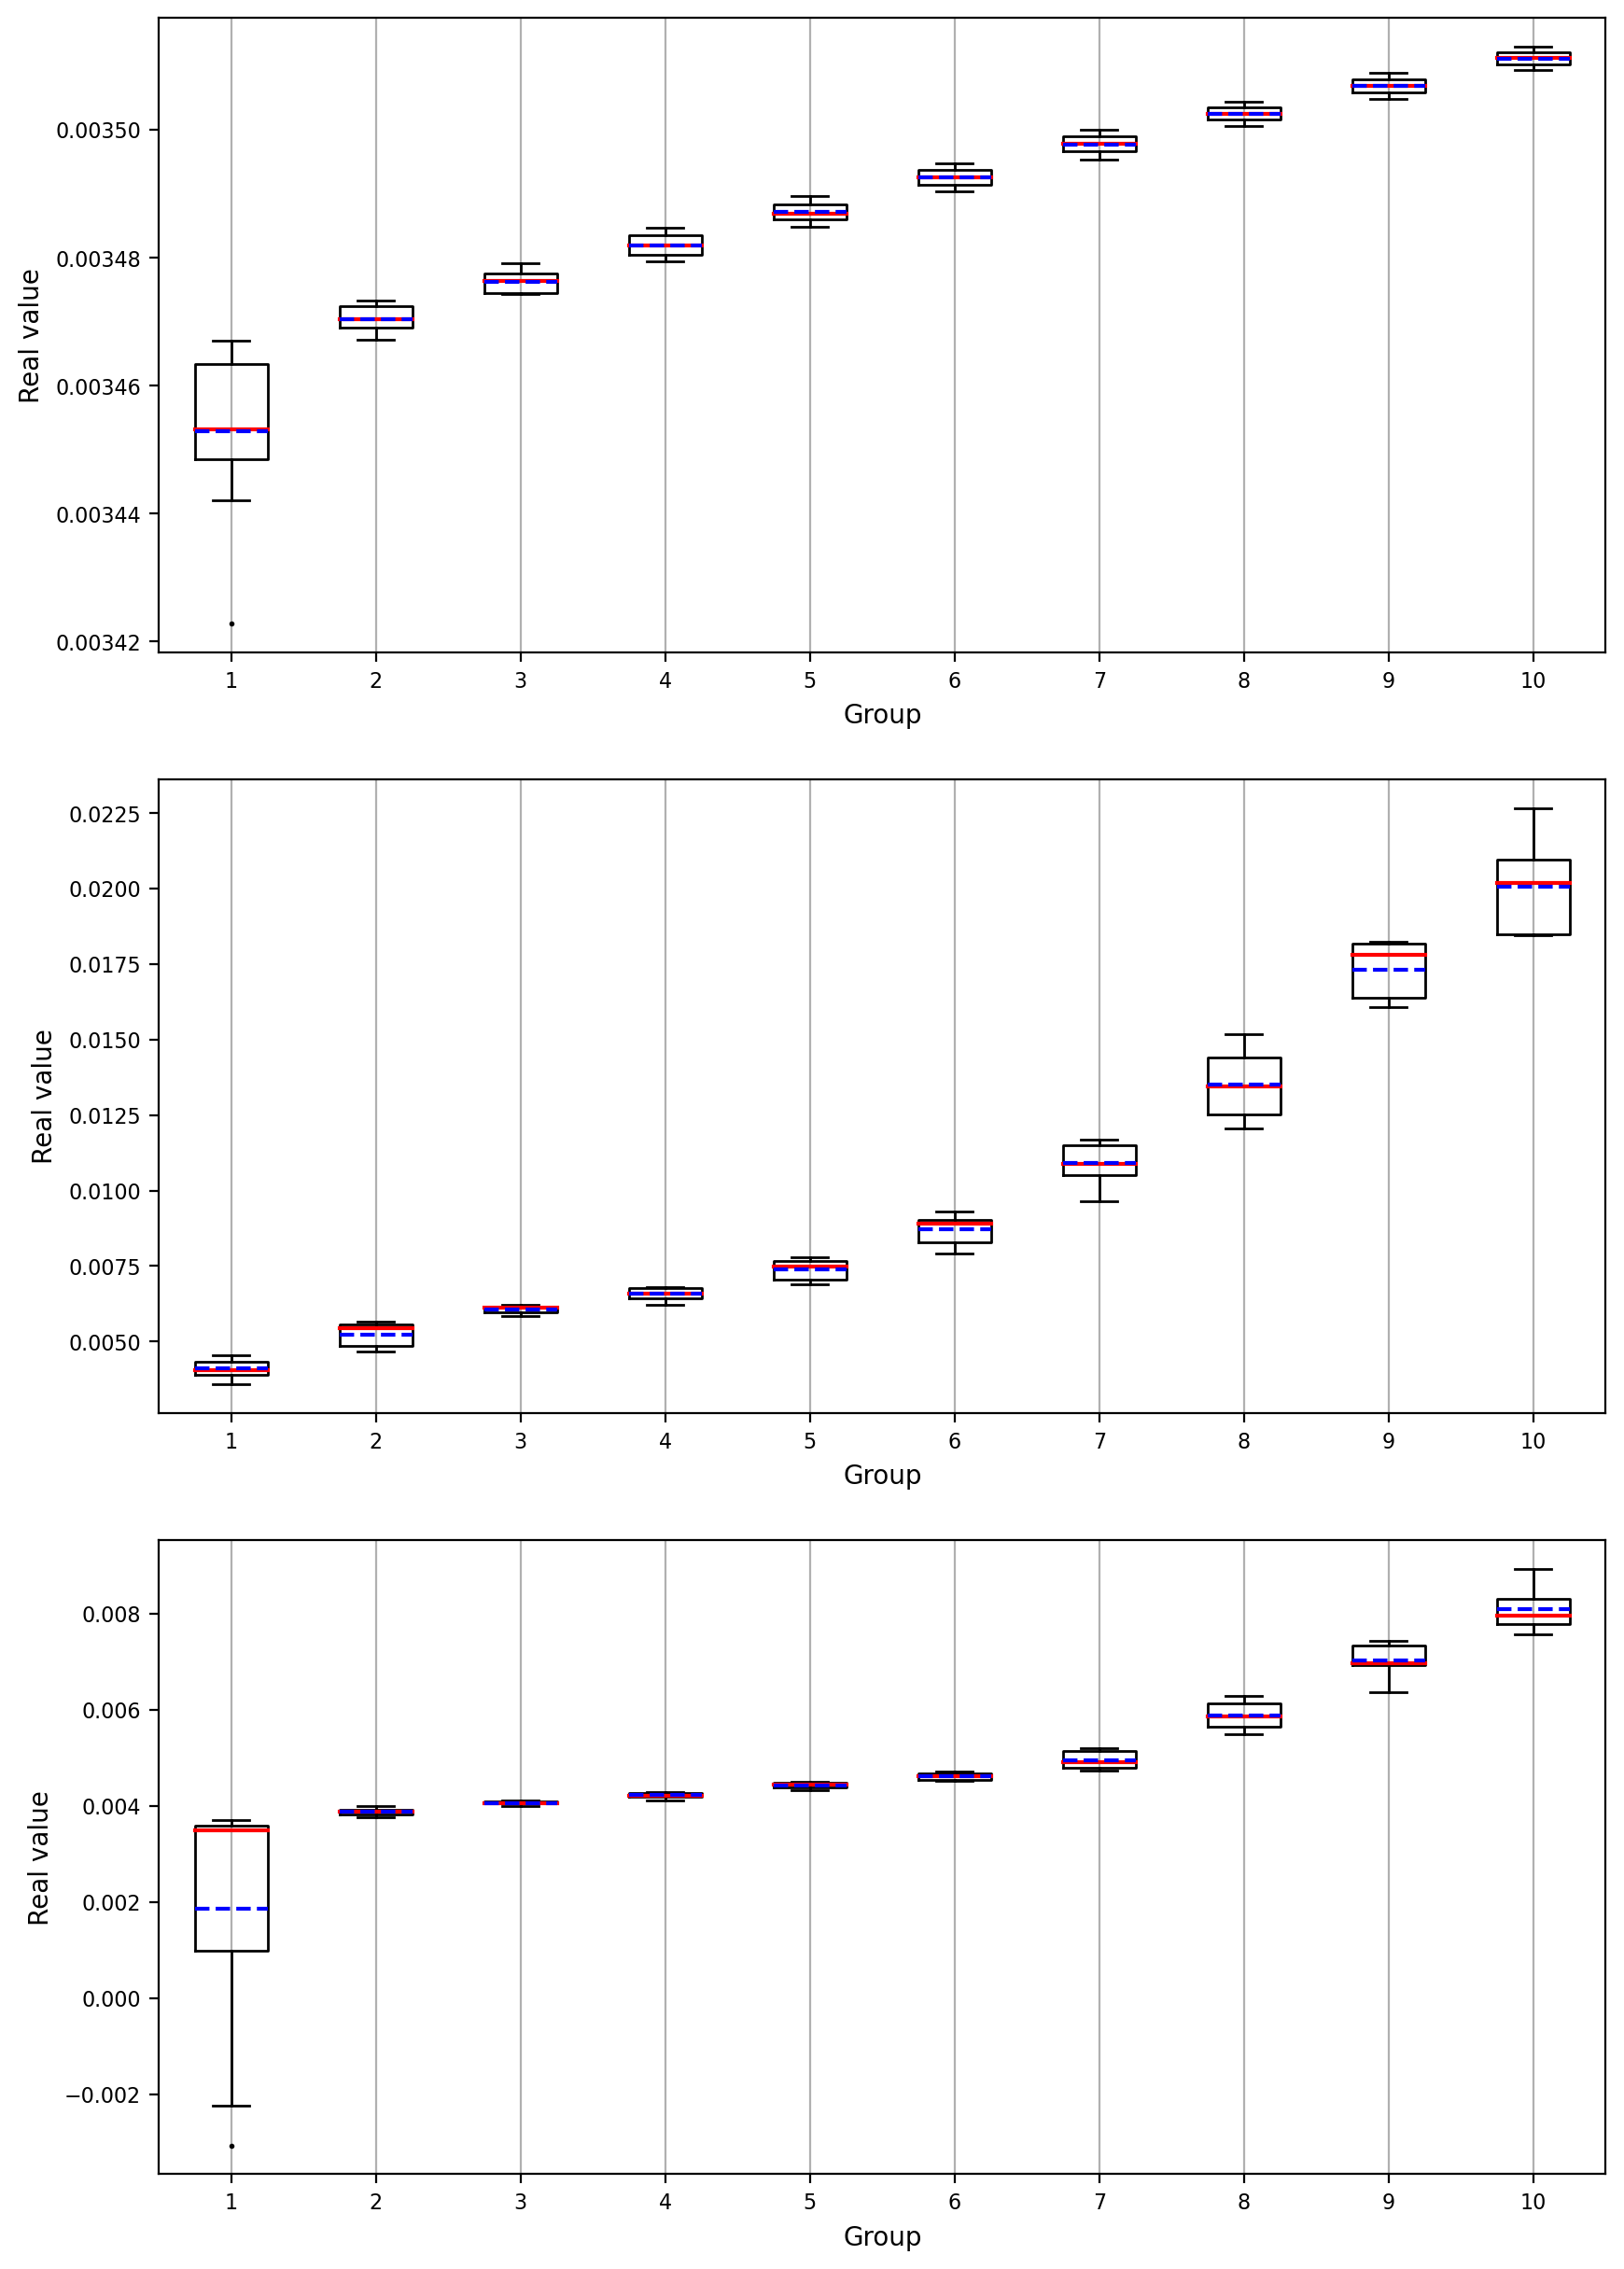

In [265]:
temp = pd.DataFrame()
temp['real'] = test_y
plt.figure(figsize=(10, 15), dpi=200)

# ARIMA
temp['predicted'] = ARIMA_split1_inference
temp['group'] = pd.qcut(temp['predicted'], 10, labels=range(10))
grouped_predict = [output['predicted'].values for i, output in temp.groupby('group')]

ax = plt.subplot(311)
box_plot(grouped_predict, ax, 'ARIMA')

# LASSO
temp['predicted'] = LASSO_split1_inference
temp['group'] = pd.qcut(temp['predicted'], 10, labels=range(10))
grouped_predict = [output['predicted'].values for i, output in temp.groupby('group')]

ax = plt.subplot(312)
box_plot(grouped_predict, ax, 'LASSO')

# ARIMA
temp['predicted'] = XGB_split1_inference
temp['group'] = pd.qcut(temp['predicted'], 10, labels=range(10))
grouped_predict = [output['predicted'].values for i, output in temp.groupby('group')]

ax = plt.subplot(313)
box_plot(grouped_predict, ax, 'XGBoost')

plt.show()

From the graph above,
- ARIMA gives almost linear monotonicity, which is not realistic in most cases. While LASSO and XGBoost gives quadratic monotonicity, which is more common in quantile prediction since points with larger points can be predicted with higher confidence.
- ARIMA and XGBoost perfrom worse in the first quantile, which is the data points with the most decrease. This might come from the Covid-19 crisis, creating unexpected shrink which can hardly be captured by our model and feature.
- Instead, LASSO performs better on the first quantiles than the last ones. Consider information ratio as 
$$\frac{{\rm Mean}}{{\rm Variance}}$$
The increase in the variance is nearly proportional to the increase in the mean value.

#### time-rolling scheme evaluation

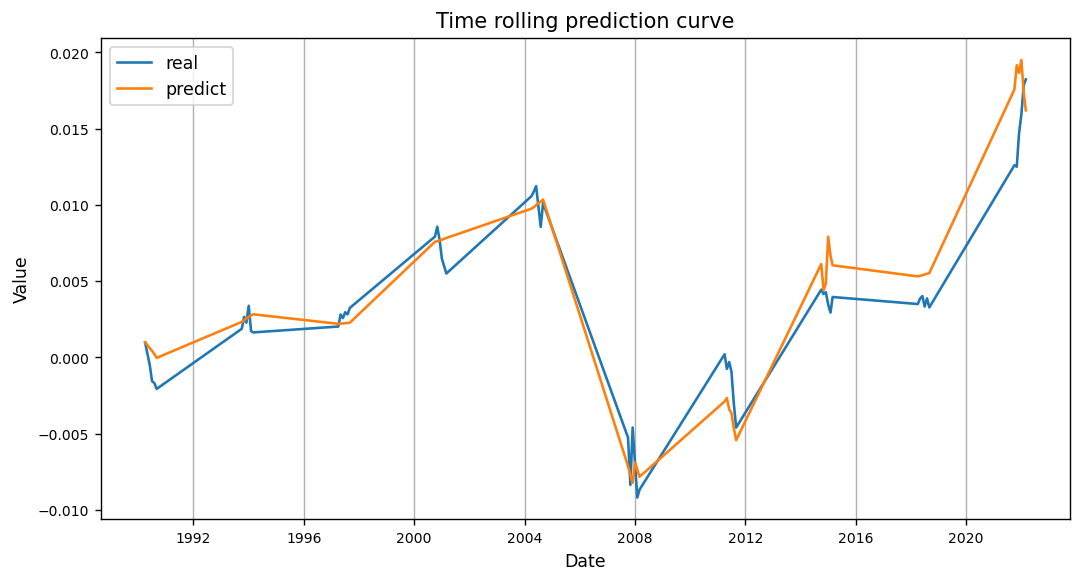

In [324]:
# learning curve
plt.figure(figsize=(10,5), dpi=125)

plt.plot(LASSO_split2_inference['real'], label='real')
plt.plot(LASSO_split2_inference['predict'], label='predict')

plt.legend(fontsize=10)
plt.grid(axis='x')
plt.xlabel("Date", fontsize=10)
plt.ylabel("Value", fontsize=10)
plt.tick_params(labelsize=8)
plt.title('Time rolling prediction curve', fontsize=12)

plt.show()

We use LASSO only for time-rolling scheme, due to dataset limit.
- Note that it is not rational to compare general metrics across different train-test split schemes. Since the time-gap in the rolling scheme will create over-estimated $R^2$ and pearson/spearman correlation.

In [302]:
# RMSE
RMSE = np.sqrt(
    mean_squared_error(y_true=LASSO_split2_inference['real'],
                       y_pred=LASSO_split2_inference['predict']))

# Out-of-sample R^2
R2 = r2_score(y_true=LASSO_split2_inference['real'],
              y_pred=LASSO_split2_inference['predict'])

# Pearson correlation
pearson = pearsonr(LASSO_split2_inference['real'],
                   LASSO_split2_inference['predict'])[0]

# spearman correlation
spearman = spearmanr(LASSO_split2_inference['real'],
                     LASSO_split2_inference['predict'])[0]

In [304]:
general_eval = pd.DataFrame()
general_eval['RMSE'] = [RMSE]
general_eval['R2'] = [R2]
general_eval['Pearson'] = [pearson]
general_eval['Spearman'] = [spearman]
general_eval.index = ['LASSO:rolling']
for col in general_eval.columns:
    general_eval[col] = general_eval[col].apply(lambda x: '%.3g'%x)
general_eval

,RMSE,R2,Pearson,Spearman
LASSO:rolling,0.00206,0.886,0.96,0.961


#### Significant features given by time-rolling LASSO

- Since there is high multicolinearity in the dataset, we can't simply test the stability for a given feature.
- For example, we can not use permutation test over the null hypothesis that $\hat{\beta_0}$ is a constant over time.
- It is more rational to test the coefficient of a cluster of features with similar financial meanings.

In [315]:
mean_coefs = np.mean(np.array(coefs), axis=0)
mean_coefs

array([-1.61809974e-06,  2.14541735e-08,  0.00000000e+00,  0.00000000e+00,
       -2.94930623e-08,  0.00000000e+00,  5.42369166e-07, -1.32659171e-06,
        3.91006614e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [319]:
np.array(features)[np.where(mean_coefs != 0)]

array(['GDP', 'M2', 'Psave', 'Popu', 'Salary', 'Nasdaq'], dtype='<U15')

#### The most significant & stable feature

In [320]:
features[7]

'Salary'

- Still, we can not say there is cause-effect relationship between the salary and the home price index. 
- All we know is Salary might bring strong prediction power and such power is stable and significant over time.

---
# 7. Conclusion & Discussions

### Conclusions

In this project, we
- Use public Fredapi to collect the S&P/Case-Shiller U.S. National Home Price Index and other indexes that might be relevant to this HPIX such as GDP, M2, Personal saving, Salary level...
- Do data cleaning & feature engineering and transformation for prediction and to satisfy the model hypothesis.
- Design two train-test split method and build 3 models for the regression task:
    - Baseline: ARIMA
    - Improved: LASSO / XGBoost
- Train / predict over the schemes and implement several evaluation metric, including general ones like RMSE, $R^2$ and correlation. And other metrics as stratification monotonicity and parameter stability.
- After comparison between the model performance, we tell that
    - Traditional time-series ARIMA can hardly capture the movement of the HPIX, where the predicted variance decay quickly over time and converge to the mean.
    - LASSO and XGBoost gives similar performance under general split method and metrics, reaching about 70% pearson and 50% spearman out-of-sample data.
    - Although there is over-estimated bias, the time-rolling scheme can improve the prediction power of LASSO. Possible reasons comes from the transition of in-sample & out-of-sample data distribution. **Update our model in time is likely to help to capture the change in market style.**

### Problems & Improvements

- The pandamic in 2020 and crisis in 2008 can hardly be captured with our features.
- Such crisis can be seen as outliers and might be mitigated by least absolute error regression ($L_1$ error).
- Due to the limit of dataset, we can hardly build some equivalent testing set to compare the performance between the 2 
split methods.
- Also due to the limit of dataset, the complexity of model is constrained, NNs are not recommended.
